In [3]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname as up
import geopandas as gpd
import shutil
from tqdm import tqdm
import rioxarray
import shapely
from itertools import product
from rasterio import windows
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask, raster_geometry_mask
from shapely.geometry import box
import pandas as pd

In [5]:
cur_path = os.path.abspath("..")
sharp_z7_dem = os.path.join(cur_path, 'raw_data', 'SHARP', 'zone7_resample.tif')
sharp_z8_dem = os.path.join(cur_path, 'raw_data', 'SHARP', 'zone8_resample.tif')

In [63]:
z7_src = rasterio.open(sharp_z7_dem)
z7_img = z7_src.read(1)


In [64]:
unique, counts = np.unique(z7_img, return_counts=True)

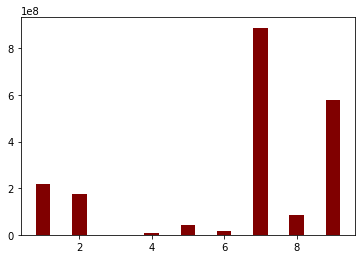

In [65]:
plt.bar(list(unique)[1:], list(counts)[1:], color ='maroon', width = 0.4)
plt.show()

In [66]:
z8_src = rasterio.open(sharp_z8_dem)
z8_img = z8_src.read(1)


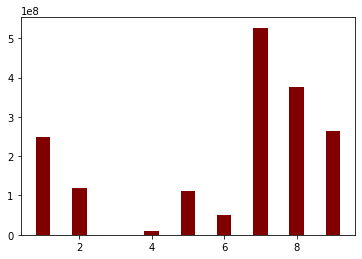

In [67]:
unique_8, counts_8 = np.unique(z8_img, return_counts=True)
plt.bar(list(unique_8)[1:], list(counts_8)[1:], color ='maroon', width = 0.4)
plt.show()

In [ ]:
counts[1:] / sum(counts[1:])

In [111]:
def get_tile_geom(tile_tif, crs=None):
    
    rds = rioxarray.open_rasterio(tile_tif)
    
    if crs is not None:

        assert isinstance(crs, str)
        
        rds_proj = rds.rio.reproject(crs)
        minx, miny, maxx, maxy = rds_proj.rio.bounds()
        geometry = shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
    
    else:
        
        minx, miny, maxx, maxy = rds.rio.bounds()
        geometry = shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
    
    return geometry


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def cropping_bands(ref_img_path, ups_img, outfile):
    
    """
    ref_img_path: input 10m resolution band
    ups_img_path: input low resolution band (rasterio.open() output)
    outfile: output low resolution band with geom alinged with ref_img
    """

    ref_img = rasterio.open(ref_img_path)
    # get the geometry of the reference high resolution band
    geom = box(*ref_img.bounds)
    
#     ups_img = rasterio.open(ups_img_path)
    cropped, crop_transf = mask(ups_img, [geom], crop=True, filled=False, all_touched=False)
    
    c, h, w = cropped.shape
    
    meta = ref_img.meta
    meta['width'], meta['height'] = w, h
    meta['transform'] = crop_transf
    meta["count"] = c

    with rasterio.open(outfile, 'w', **meta) as dst:
        dst.write(cropped)

def get_pixel_count(rst):
    
    img = rasterio.open(rst).read(1)
    unique, count = np.unique(img, return_counts=True)
    
    pixel_count = {}
    
    for i in range(len(unique)):
        
        if not unique[i] in pixel_count.keys():
            pixel_count[unique[i]] = count[i]
    
    for j in range(0, 10):
        if not j in pixel_count.keys():
            pixel_count[j] = 0
    
#     pixel_count_new = {k: v for k, v in sorted(pixel_count.items(), key=lambda item: item[0])}
    
    pixel_count_new = [str(v) for k, v in sorted(pixel_count.items(), key=lambda item: item[0])]
    pixel_count_str = '|'.join(pixel_count_new)

    return pixel_count_str


In [ ]:
# NAIP 2014 data processing

"""
Step 1.
Get the geometry index of each image tile and all index is projected to 26918
gdaltindex -t_srs EPSG:26918 -src_srs_name src_srs naip_va_2014_index.shp 2014_VA/*.tif
gdaltindex -t_srs EPSG:26918 -src_srs_name src_srs naip_md_2015_index.shp 2015_MD/*.tif

Step 2.
Desktop, overlay the index shapefile with the zone 7 and zone 8 dem tiff data, and select the tiles that are 
overlay with the zone data, export this geojson file and saved as NAIPva_2014_overlapIndex.geojson and 
NAIPmd_2015_overlapIndex.geojson

Step 3. 
Copy all image tiles to the NAIP folder under raw_data. These image tiles will be used to construct image patches for training
and testing.

"""

NAIP_dir = os.path.join(up(up(cur_path)), 'VIMS', 'NAIP')
VA_dir = os.path.join(NAIP_dir, 'VA_NAIP_2014_6278', '2014_VA')
MD_dir = os.path.join(NAIP_dir, 'MD_NAIP_2015_6275', '2015_MD')
dest_dir = os.path.join(cur_path, 'raw_data', 'NAIP_z7z8')

overlap_index_VA = os.path.join(cur_path, 'data', 'NAIP', 'NAIPva_2014_overlapIndex.geojson')
overlap_index_MD = os.path.join(cur_path, 'data', 'NAIP', 'NAIPmd_2015_overlapIndex.geojson')

In [ ]:
va_gdf = gpd.read_file(overlap_index_VA)
md_gdf = gpd.read_file(overlap_index_MD)

In [ ]:
all_va = [os.path.join(NAIP_dir, 'VA_NAIP_2014_6278', file) for file in va_gdf.location.tolist()]
all_md = [os.path.join(NAIP_dir, 'MD_NAIP_2015_6275', file) for file in md_gdf.location.tolist()]
all_files = all_va + all_md

In [ ]:
cope_file = False

while cope_file:
    cope_file = False
    for file in tqdm(all_files):
        shutil.copy(file, dest_dir)

In [8]:
# Processing SHARP classification map in z7 and z8, which covers the area of Maryland and Virginia
# Processing data clip to N X N dimension, and remove invalid data patches

dem_tiles = [sharp_z7_dem, sharp_z8_dem]
image_clipping = False
cropped_path = os.path.join(cur_path, "data/NAIP/sharp_image_patches_512")
valid_dest_dir = os.path.join(cur_path, "data/NAIP/sharp_valid_image_patches_512")


N = 512

while image_clipping:
    
    image_clipping = False
    valid_patch_count = 0
    
    for tile in tqdm(dem_tiles):
        
        output_filename = os.path.basename(tile).split('.')[0] + "_{}-{}.tif"  #'VRGB_2017_tile_{}-{}.tif'
        
        with rasterio.open(tile) as inds:

            meta = inds.meta.copy()

            for window, transform in get_tiles(inds, N, N):

                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height

                outpath = os.path.join(cropped_path, output_filename.format(int(window.col_off), int(window.row_off)))

                with rasterio.open(outpath, 'w', **meta) as outds:
                    outds.write(inds.read(window=window))
                
                patch_src = rasterio.open(outpath)
                patch_src_array = patch_src.read(1)
                unique, counts = np.unique(patch_src_array, return_counts=True)

                if len(unique) == 1 and (unique[0]==0 or unique[0]==-1.797693e+308):
                    pass
                else:
                    valid_patch_count += 1
                    shutil.copy(outpath, valid_dest_dir)

100%|██████████| 2/2 [3:34:19<00:00, 6429.85s/it]  


In [ ]:
# all_zone_patches = [f for f in os.listdir(cropped_path) if f.endswith(".tif")]

# move_valid_tiles = True
# valid_dest_dir = os.path.join(cur_path, "data/NAIP/sharp_valid_image_patches_512")

# while move_valid_tiles:
    
#     move_valid_tiles = False
    
#     valid_patch_count = 0

#     for patch in tqdm(all_zone_patches):
#         patch_path = os.path.join(cropped_path, patch)
#         patch_src = rasterio.open(patch_path)
#         patch_src_array = patch_src.read(1)
#         unique, counts = np.unique(patch_src_array, return_counts=True)

#         if len(unique) == 1 and (unique[0]==0 or unique[0]==-1.797693e+308):
#             print(patch_path)
#         else:
#             valid_patch_count += 1
#             shutil.copy(patch_path, valid_dest_dir)

In [11]:
# Working on NAIP data processing

z7z8_NAIP = os.path.join(cur_path, 'raw_data', 'z7z8_NAIP.tif')
crop_NAIP_out = os.path.join(cur_path, "data/NAIP/NAIP_image_patches_512")
valid_patches = [f for f in os.listdir(valid_dest_dir) if f.endswith(".tif")]

In [16]:
NAIP_cropping = False

outbound_patches = []

while NAIP_cropping:
    NAIP_cropping = False
    
    naip_src = rasterio.open(z7z8_NAIP)
    
    for valid_patch in tqdm(valid_patches):
        valid_patch_path = os.path.join(valid_dest_dir, valid_patch)
        # cropped NAIP output path
        naip_cropped_path = os.path.join(crop_NAIP_out, valid_patch)
        try:
            cropping_bands(valid_patch_path, naip_src, naip_cropped_path)
        except:
            print(valid_patch_path)
            outbound_patches.append(valid_patch)
    

In [49]:
# Generate a csv file to record the directory of images and the corresponding labels

valid_NAIP = [i for i in os.listdir(crop_NAIP_out) if i.endswith('.tif')]
df = pd.DataFrame (valid_NAIP, columns = ['patch_name'])
df['patch_path'] = df['patch_name'].apply(lambda x: os.path.join(crop_NAIP_out, x))
df['label_path'] = df['patch_name'].apply(lambda x: os.path.join(cropped_path, x))
#df.to_csv(os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_512.csv'), index=False)

In [47]:
invalid_shape = []
for i in tqdm(valid_NAIP):
    
    valid_path = os.path.join(crop_NAIP_out, i)
    
    if os.path.isfile(valid_path):
        img = rasterio.open(valid_path).read()

        if img.shape[1] != 512 or img.shape[2] != 512:
            invalid_shape.append(i)
            os.remove(valid_path)

100%|██████████| 15763/15763 [16:13<00:00, 16.19it/s]  


In [118]:
label_path = os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_512.csv')
label_df = pd.read_csv(label_path)
label_df['pixel_count'] = label_df['label_path'].apply(lambda x: get_pixel_count(x))

In [120]:
# create column to count each label class
label_df['class_0'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[0]))
label_df['class_1'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[1]))
label_df['class_2'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[2]))
label_df['class_3'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[3]))
label_df['class_4'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[4]))
label_df['class_5'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[5]))
label_df['class_6'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[6]))
label_df['class_7'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[7]))
label_df['class_8'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[8]))
label_df['class_9'] = label_df['pixel_count'].apply(lambda x: int(x.split('|')[9]))

In [133]:
# label_df.to_csv(os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_withCount_512.csv'), index=False)

In [131]:
# hl_df = label_df[(label_df['class_1']>0) | (label_df['class_2']>0)]
# hl_df.to_csv(os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_highlow_512.csv'), index=False)

In [6]:
df = pd.read_csv(os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_highlow_512.csv'))

In [11]:
high_low_50000 = df[(df.class_1 > 50000) | (df.class_2 > 50000)]
high_low_50000.to_csv(os.path.join(cur_path, 'data', 'NAIP', 'NAIP_data_highlow_50000.csv'), index=False)